# Path planning

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.linalg as linalg

Just a bunch of helper methods

Note here that we're using $\varphi(z)$ to be an approximation of the hard-wall constraint that we actually want in our optimization problem, where we define

$$
\varphi(z) \equiv \frac{1}{1+e^z}.
$$

We can easily work out the derivative to be

$$
\varphi'(z) = \varphi(z)(\varphi(z) - 1)
$$

In [3]:
def circle(x, y, r, n=100):
    t = linspace(0, 2*pi, n)
    return r*cos(t)+x, r*sin(t)+y

def ϕ(x):
    q = np.exp(x)
    return 1/(1+q)

def dϕ(x):
    q = 1/(1+np.exp(x))
    return -q*(1-q)

A plot of what the different radii penalty look like for varying curvature parameters $C$.

Text(0,0.5,'Function Value')

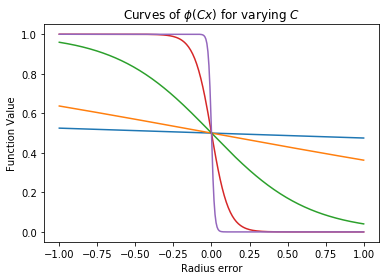

In [4]:
x = linspace(-1, 1, 300)
for l in logspace(-1, 2, 5):
    plot(x, ϕ(l*x))

title('Curves of $\phi(Cx)$ for varying $C$')
xlabel('Radius error')
ylabel('Function Value')

A simple initial test using just a circle at point $(0,0)$ with radius $1/2$

In [5]:
N_points = 100
points = np.zeros((2, N_points)) # the initial set of points
points[0,:] = np.linspace(-1, 1, N_points)

circ_pos = np.array([0, 0.1])[:,newaxis]
circ_radius2 = np.array([(1/2.)**2])

Functions returning derivatives and evaluations of the loss function
$$
\ell(\theta, c, R, \eta) = \sum_i\left(\sum_j \varphi(C(\lVert x_i - c_j \lVert_2^2) - R_j^2) + \eta \lVert x_i - x_{i+1}\lVert_2^2\right)
$$

This energy function has gradient
$$
\nabla \ell(\theta, c, R, \eta) = \sum_i \left(\sum_j \left[2C\varphi'(C\lVert x_i - c_j \lVert_2^2 - R^2)(x_i-c_j)\right] - \eta (x_{i-1} - 2x_i + x_{i+1})\right)
$$

which we plug in directly to our optimization algorithm. In particular, note that we do not want to update the initial and final positions (i.e. we want those positions to be constrained to their initial positions), which is why their gradients are set to zero.

In [6]:
vec_ϕ = np.vectorize(ϕ)
vec_dϕ = np.vectorize(dϕ)

def compute_loss(curr_pos, circ_mat, circ_rad, C):
    all_dist = C*(linalg.norm(circ_mat - curr_pos[:,newaxis], axis=0)**2/circ_rad - 1)
    return np.sum(ϕ(all_dist))
    
def loss(pos_mat, circ_mat, circ_rad, C):
    return np.sum(np.apply_along_axis(lambda x: compute_loss(x, circ_mat, circ_rad, C), 0, pos_mat))

def compute_dloss(curr_pos, circ_mat, circ_rad, C):
    dif_mat = curr_pos[:,newaxis] - circ_mat
    all_dist = C*(linalg.norm(dif_mat, axis=0)**2/circ_rad - 1)
    return 2*C*np.sum(dϕ(all_dist)*dif_mat/circ_rad, axis=1)

def dloss(pos_mat, circ_mat, circ_rad, C):
    return np.apply_along_axis(lambda x: compute_dloss(x, circ_mat, circ_rad, C), 0, pos_mat)

def complete_dloss(pos_mat, circ_mat, circ_rad, C, K):
    dloss_obstacles = dloss(pos_mat, circ_mat, circ_rad, C)[:,1:-1]
    diff_mat = -pos_mat[:,:-2] + 2*pos_mat[:,1:-1] - pos_mat[:,2:]
    zeros_mat = np.zeros(2)[:,newaxis]
    return np.c_[zeros_mat, dloss_obstacles + K*diff_mat, zeros_mat]

def complete_loss(pos_mat, circ_mat, circ_rad, C, K):
    loss_obstacles = loss(pos_mat, circ_mat, circ_rad, C)
    loss_diff = sum(linalg.norm(pos_mat[:,1:] - pos_mat[:,:-1], axis=0))
    return loss_obstacles + K*loss_diff


Plot the initial path guess

In [7]:
def plot_path(points, circles, radii, plot_title=''):
    plot(points[0,:], points[1,:], '-')
    for idx in range(len(radii)):
        curr_cirlce = circle(circles[0, idx], circles[1, idx], radii[idx])
        plot(curr_cirlce[0], curr_cirlce[1], 'r')
        
    gca().set_aspect('equal')
    title(plot_title)
    xlim(-1, 1)
    ylim(-.7, .7)

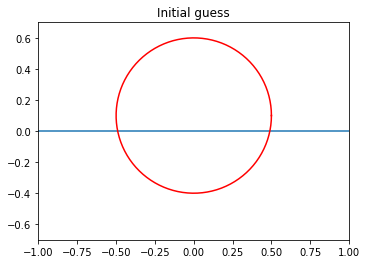

In [8]:
plot_path(points, circ_pos, sqrt(circ_radius2), 'Initial guess')

Optimize that ish

FileNotFoundError: [Errno 2] No such file or directory: 'simple_step/iter00.png'

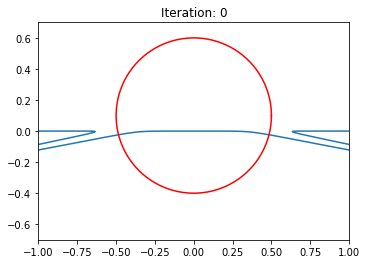

In [9]:
MAX_ITER = 500
INIT_STEP_SIZE = 1e-1
COOLING_SCHEDULE = 1.005
INIT_CONSTRAINT_HARDNESS = 10

curr_pos = copy(points)
constraint_hardness = INIT_CONSTRAINT_HARDNESS

count = 0

for i in range(MAX_ITER+1):
    curr_pos -= INIT_STEP_SIZE*dloss(curr_pos, circ_pos, circ_radius2, constraint_hardness)
    constraint_hardness *= COOLING_SCHEDULE
    
    if i%5==0:
        plot_path(curr_pos, circ_pos, sqrt(circ_radius2), 'Iteration: {}'.format(i))
        savefig('simple_step/iter{:02d}.png'.format(count))
        close()
        count += 1
        

The idea here is to use the classical momentum technique; e.g. consider some 'velocity' vector $v_t$, where $\eta > 0$ is the learning rate, and where $0 < \mu < 1$ is the momentum coefficient, then we have the following scheme, for $\theta_t$ being the argument at iteration $t$, which we're minimizing over:

$$
\begin{align}
v_t &=& \mu v_{t-1} - \eta \nabla f(\theta_{t-1})\\
\theta_t &=& \theta_{t-1} + v_t
\end{align}
$$

Running this new iterative scheme is much faster than just vanilla gradient descent, though it doesn't fully optimize the function (e.g. compare the `spring_backtracking_momentum` to `spring_step_backtracking`), so it might be worth doing a second-pass using just a simple gradient descent with line search to complete the optimization. There's also this question of whether this would even be necessary or if we just want to do 'good enough' for our purposes.

Note also that we send $C\to\infty$ at the same time that we optimize the objective: this is done to save time. E.g. while we could optimize first over each $C$ and then rework the problem after each $C$ has converged (which may be a possibility to evaluate); in general, the intial steps will be quite crappy, and we don't really care about convergence for small $C$ (soft-wall constraints), but rather we only really want the solution to the problem for larger $C$; this seems like a reasonable tradeoff, even though we may not be guaranteed to reach a local optimum point here, anyways.

In [18]:
MAX_ITER = 1000
INIT_STEP_SIZE = 1e-3
MIN_STEP = 1e-2
RESET_STEP_SIZE = 1e-7
COOLING_SCHEDULE = 1.0001
FAST_COOLING_SCHEDULE = 1.1
INIT_CONSTRAINT_HARDNESS = 1
INIT_SPRING_HARDNESS = 20
MAX_TIME_INCREASE = 10
MOMENTUM_CHANGE = .2

curr_pos = copy(points)
constraint_hardness = INIT_CONSTRAINT_HARDNESS

circ_pos = array([[-.5, .1], [-.15, -.5], [.25, .25], [.5, -.05], [-.25, .5]]).T
circ_radius2 = array([.2, .4, .25, .2, .25])**2

count = 0
curr_step = INIT_STEP_SIZE
prev_loss = float('inf')
momentum = .99

prev_velocity = np.zeros(curr_pos.shape)
curr_velocity = copy(prev_velocity)

times_increased = 0
converged = False

for i in range(MAX_ITER+1):
    while True:
        # Accelerated gradient (e.g. with momentum)
        curr_velocity = momentum * prev_velocity - curr_step*complete_dloss(curr_pos, circ_pos, circ_radius2, constraint_hardness, INIT_SPRING_HARDNESS)
        proposed_pos = curr_pos + curr_velocity
        curr_loss = complete_loss(proposed_pos, circ_pos, circ_radius2, constraint_hardness, INIT_SPRING_HARDNESS)
        
        # Ensure decrease
        if curr_loss < prev_loss:
            curr_pos = proposed_pos
            prev_velocity = curr_velocity
            prev_loss = curr_loss
            curr_step *= 2
            times_increased = 0
            break
        # Otherwise, decrease the step size
        else:
            curr_step *= .8
        if curr_step < MIN_STEP:
            if times_increased > MAX_TIME_INCREASE:
                print('Cooling schedule is finished. Converged to final result.')
                converged = True
                break
            # Once the cooling step converges, increase the constraint hardness such that the optimization
            # Can finish
            print('Converged in cooling step; increasing schedule'
                  '(C={}) and resetting velocity'.format(constraint_hardness))
            prev_velocity = np.zeros(prev_velocity.shape)
            constraint_hardness *= FAST_COOLING_SCHEDULE
            
            curr_step = RESET_STEP_SIZE;
            times_increased += 1

    if converged:
        break
    constraint_hardness *= COOLING_SCHEDULE
    
    
    if i%10==0:
        plot_path(curr_pos, circ_pos, sqrt(circ_radius2), 'Iteration: {}'.format(i))
        savefig('image_output/spring_backtracking_momentum_decrease/iter{:02d}.png'.format(count))
        close()
        count += 1
        print('On iteration {}'.format(i))
        print('Current step size : {}'.format(curr_step))
        
       

On iteration 0
Current step size : 0.002
Converged in cooling step; increasing schedule(C=1.0006001500200012) and resetting velocity
On iteration 10
Current step size : 3.2e-06
On iteration 20
Current step size : 0.0032768
Converged in cooling step; increasing schedule(C=1.1026430382275685) and resetting velocity
On iteration 30
Current step size : 1.28e-05
On iteration 40
Current step size : 0.0131072
Converged in cooling step; increasing schedule(C=1.2149709349108615) and resetting velocity
On iteration 50
Current step size : 0.0001024
Converged in cooling step; increasing schedule(C=1.3383403003142242) and resetting velocity
On iteration 60
Current step size : 6.4e-06
On iteration 70
Current step size : 0.0065536
Converged in cooling step; increasing schedule(C=1.4745315767080815) and resetting velocity
On iteration 80
Current step size : 0.0001024
Converged in cooling step; increasing schedule(C=1.6249067898614513) and resetting velocity
On iteration 90
Current step size : 4e-07
On

/Users/Guille/Documents/Stanford/Personal/AUVSI/path-planning/venv/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/Users/Guille/Documents/Stanford/Personal/AUVSI/path-planning/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


On iteration 490
Current step size : 3.2e-06
On iteration 500
Current step size : 0.0032768
Converged in cooling step; increasing schedule(C=13.790394855829028) and resetting velocity
On iteration 510
Current step size : 3.2e-06
Converged in cooling step; increasing schedule(C=15.190685359198348) and resetting velocity
On iteration 520
Current step size : 2e-07
On iteration 530
Current step size : 0.0002048
On iteration 540
Current step size : 0.06871947673600003
Converged in cooling step; increasing schedule(C=16.74990345722552) and resetting velocity
On iteration 550
Current step size : 1.28e-05
On iteration 560
Current step size : 0.0131072
On iteration 570
Current step size : 0.0405648192073034
Converged in cooling step; increasing schedule(C=18.476553212092597) and resetting velocity
On iteration 580
Current step size : 5.12e-05
On iteration 590
Current step size : 0.0524288
Converged in cooling step; increasing schedule(C=20.366932079103076) and resetting velocity
On iteration 60